In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from statistics import mode
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
#Create a directory for the figures if it does not already exist.
os.makedirs('./Figures', exist_ok=True)

In [3]:
#Read in the cleaned data generated by Data_Cleaning. Save that data as a pandas dataframe, df.
df = pd.read_csv('./Cleaned_Data/IX_Full_Data_wPCA.csv')

#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 
#Therefore we should multiply the given cycles by 2 to get the true cycle number.
df["cycle number"] = df["cycle number"].apply(lambda x: 2*x)
df["Cycles Until Fail"] = df["Cycles Until Fail"].apply(lambda x: 2*x)#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 

# Adding a classification taget and an additional feature that we can use for regression. 

# Adding a column for the true category (1 if the battery lasts over 200 cycles) (0 otherwise).
to_num=df['label']
to_num=to_num.map({'25C01':1.0,'25C02':0.0,'25C03':0.0,'25C04':0.0,'25C05':0.0,'25C06':0.0,'25C07':0.0,'25C08':0.0,
            '35C01':1.0,'35C02':1.0,'45C01':1.0,'45C02':1.0})
df['category']=to_num

# Adding temperature as a column. 
temdf=df['label']
temdf=temdf.map({'25C01':25.0,'25C02':25.0,'25C03':25.0,'25C04':25.0,'25C05':25.0,'25C06':25.0,'25C07':25.0,
                 '25C08':25.0,'35C01':35.0,'35C02':35.0,'45C01':45.0,'45C02':45.0})
df['temperature']=temdf

df[df['cycle number']==2]

,label,cycle number,Capacity/mA.h,Norm_Cap,Cycles Until Fail,20004.453 Re,15829.126 Re,12516.703 Re,9909.4424 Re,7835.48 Re,...,0.06443 Im,0.05102 Im,0.04042 Im,0.03192 Im,0.02528 Im,0.01999 Im,EIS_PCA_1,EIS_PCA_2,category,temperature
0,25C01,2,37.202713,1.0,234,0.40511,0.41137,0.41745,0.42497,0.43232,...,0.15522,0.18114,0.21622,0.25196,0.28312,0.31814,-1.538090,0.299827,1.0,25.0
349,25C02,2,35.060836,1.0,12,0.28954,0.29528,0.30583,0.31382,0.32439,...,0.18544,0.20632,0.23622,0.27843,0.32207,0.36078,0.583423,0.572418,0.0,25.0
530,25C03,2,36.771703,1.0,164,0.29269,0.29965,0.31052,0.32220,0.33091,...,0.21709,0.24284,0.28342,0.32985,0.37178,0.41546,1.855889,0.574404,0.0,25.0
732,25C04,2,35.534219,1.0,114,0.28271,0.29153,0.29794,0.30711,0.31650,...,0.19507,0.22307,0.25168,0.28749,0.33797,0.39827,0.595398,0.442635,0.0,25.0
767,25C05,2,37.210831,1.0,152,0.37181,0.37908,0.38590,0.39350,0.40243,...,0.16543,0.18818,0.21387,0.25147,0.29559,0.33756,-1.764882,0.073158,0.0,25.0
1095,25C06,2,35.992184,1.0,120,0.30841,0.31570,0.32282,0.33259,0.34361,...,0.17907,0.19937,0.22852,0.26499,0.30185,0.34337,-0.372980,0.524173,0.0,25.0
1307,25C07,2,35.684646,1.0,32,0.31134,0.31953,0.32881,0.33828,0.34932,...,0.20625,0.23352,0.26153,0.29791,0.34396,0.39127,0.780288,0.551780,0.0,25.0
1447,25C08,2,33.943672,1.0,32,0.30745,0.31585,0.32548,0.33377,0.34431,...,0.22307,0.24306,0.27538,0.31835,0.35359,0.40660,1.506526,0.506956,0.0,25.0
1484,35C01,2,40.113305,1.0,218,0.29820,0.30456,0.31211,0.31850,0.32553,...,0.19875,0.22878,0.26049,0.30297,0.36258,0.44320,-3.383683,-0.699009,1.0,35.0
1810,35C02,2,40.473768,1.0,262,0.50019,0.50520,0.51151,0.51909,0.52530,...,0.15276,0.17790,0.19946,0.22596,0.26255,0.30444,-2.269225,0.246006,1.0,35.0


In [4]:
#Generate smaller, balanced dataframes with information from only early cycles. 

#Generate a dataframe with the first 20 cycles only
df_20 = df[(df['cycle number']<=20)]

#Generate a dataframe with the first 40 cycles only
df_40 = df[(df['cycle number']<=40)]

In [5]:
def run_Classification_ML(df,Train_L,Test_L,feats,model):
    feature_names=feats
    train_df = pd.DataFrame(columns = df.columns)
    for Label in Train_L:
            selected_rows = df[df['label'] == Label]
            train_df = pd.concat([train_df,selected_rows],ignore_index=True) 
    X_train = train_df[feature_names]
    y_train = train_df['category']
    
    test_df = pd.DataFrame(columns = df.columns)
    for Label in Test_L:
        #Get the correct train test splits. 
        selected_rows = df[df['label'] == Label]
        test_df = pd.concat([test_df,selected_rows],ignore_index=True) 
    X_test = test_df[feature_names]
    y_test = test_df['category']
    #Running the Model
    clf = model
    clf.fit(X_train, y_train)
    clf_pred=clf.predict(X_test)   
    return y_test.to_list(),clf_pred,clf
        


In [6]:
####
#### Train Test Split
####

[[1. 0.]
 [0. 1.]]


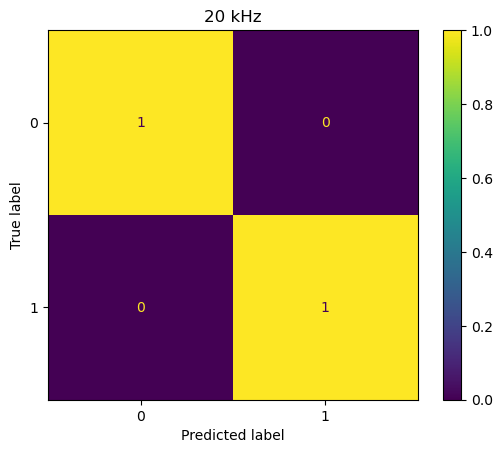

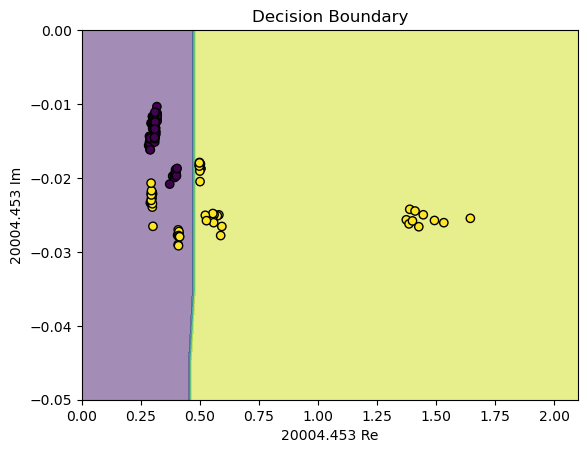

[[ 5.5853 -0.7742]]


In [7]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['20004.453 Re','20004.453 Im']

model=SVC(kernel="linear", C=5, random_state=42)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

#Normalize true normalizes over the true label count.
cm=confusion_matrix(tc,pc,normalize='true')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.title('20 kHz')
plt.savefig('./Figures/IX_TT_Conf_20KHz.png',format='png',dpi=600)
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,grid_resolution=200)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

[[0.75 0.25]
 [0.   1.  ]]


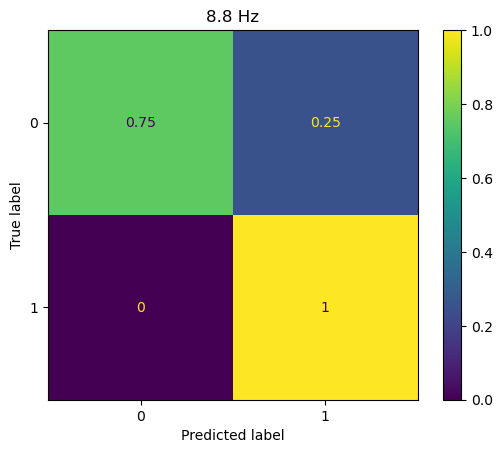

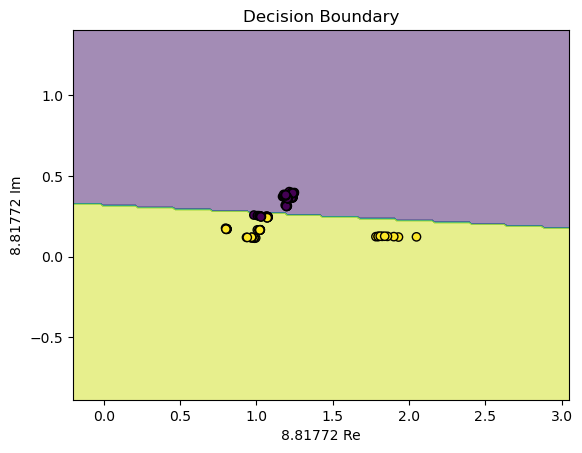

[[-0.44615562 -9.38601918]]


In [8]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['8.81772 Re','8.81772 Im']

model=SVC(kernel="linear", C=5, random_state=42)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

#Normalize true normalizes over the true label count.
cm=confusion_matrix(tc,pc,normalize='true')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.title('8.8 Hz')
plt.savefig('./Figures/IX_TT_Conf_8Hz.png',format='png',dpi=600)
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,grid_resolution=200)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
#plt.xlim(0,2.1)
#plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

[[0.75 0.25]
 [0.   1.  ]]


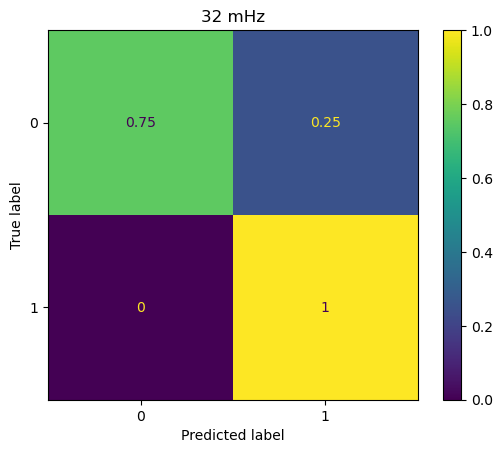

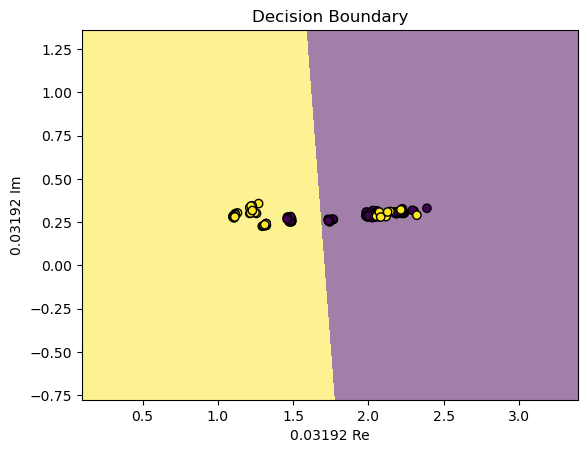

[[-2.21124 -0.19233]]


In [9]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['0.03192 Re','0.03192 Im']

model=SVC(kernel="linear", C=.5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

#Normalize true normalizes over the true label count.
cm=confusion_matrix(tc,pc,normalize='true')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.title('32 mHz')
plt.savefig('./Figures/IX_TT_Conf_30mHz.png',format='png',dpi=600)
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
#plt.xlim(0,2.1)
#plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

[[0.75 0.25]
 [0.   1.  ]]


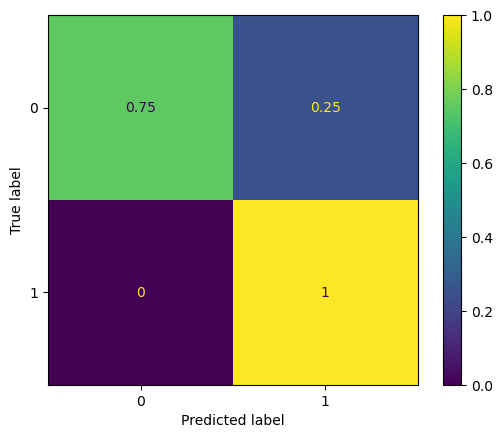

In [10]:
#Frequencies from the published literature. 
my_feats=['17.79613 Re','17.79613 Im','2.16054 Re','2.16054 Im']

model=SVC(kernel="linear", C=5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

#Normalize true normalizes over the true label count.
cm=confusion_matrix(tc,pc,normalize='true')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.savefig('./Figures/IX_TT_Conf_4paper.png',format='png',dpi=600)
plt.show()


[[0.525 0.475]
 [0.    1.   ]]


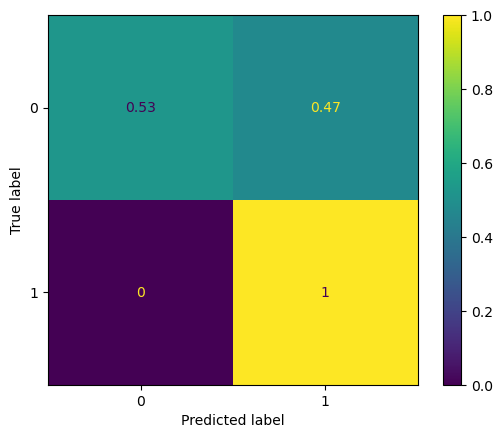

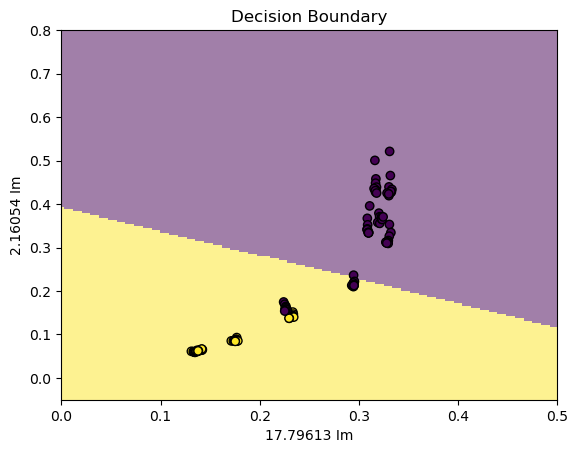

[[-4.32965 -7.8001 ]]


In [11]:
#Frequencies from the published literature. 
my_feats=['17.79613 Im','2.16054 Im']

model=SVC(kernel="linear", C=5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

#Normalize true normalizes over the true label count.
cm=confusion_matrix(tc,pc,normalize='true')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.savefig('./Figures/IX_TT_Conf_2paper.png',format='png',dpi=600)
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.xlim(0,0.5)
plt.ylim(-.05,0.8)
plt.show()
print(tmdl.coef_)


In [12]:
####
#### All Train
####

[[1.  0. ]
 [0.2 0.8]]


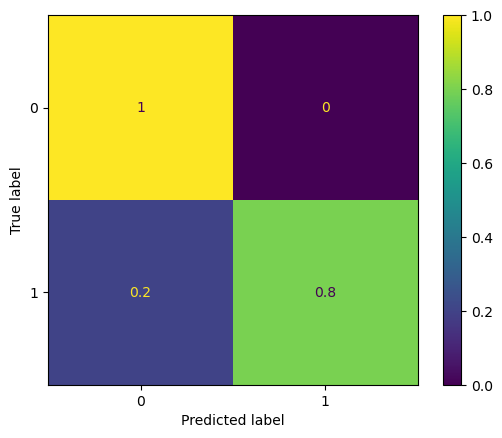

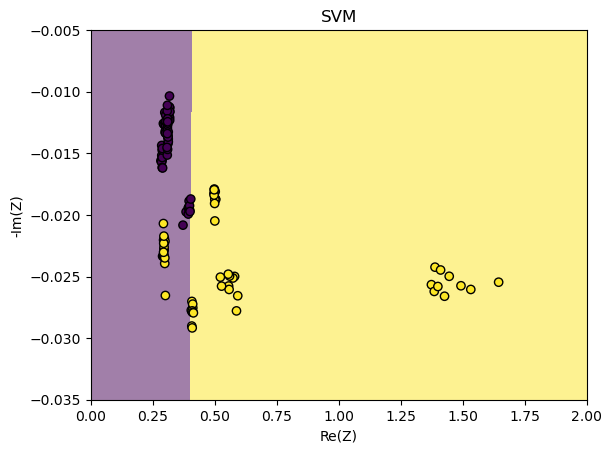

[[10.61742277 -4.17127455]]


In [13]:
#Linear SVC
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=10, random_state=42)
model=SVC(kernel="linear", C=20, random_state=42)


train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

#Normalize true normalizes over the true label count.
cm=confusion_matrix(tc,pc,normalize='true')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()



X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),800)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),800)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,plot_method='pcolormesh',grid_resolution=1000)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.xlim(0,2.0)
plt.ylim(-.035,-0.005)
plt.xlabel('Re(Z)')
plt.ylabel('-Im(Z)')
plt.title('SVM')
plt.savefig('./Figures/IX_Full_Db_SVM_20kHz.png',format='png',dpi=600)
plt.show()
print(tmdl.coef_)

[[70  0]
 [ 2 48]]


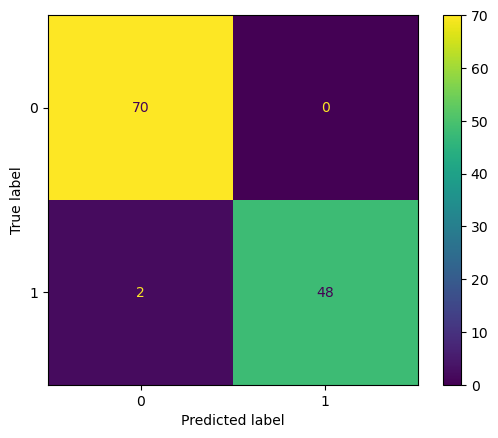

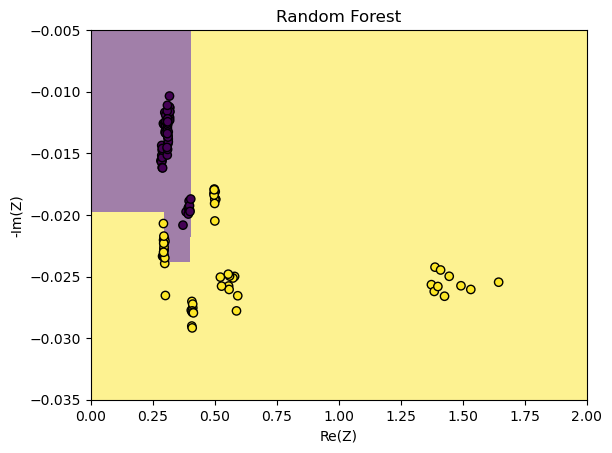

In [14]:
#RFC
my_feats=['20004.453 Re','20004.453 Im']

model=RandomForestClassifier(max_depth=5, n_estimators=3, max_features=3)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X, response_method="predict",alpha=0.5,plot_method='pcolormesh',grid_resolution=1000)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.0)
plt.ylim(-.035,-0.005)
plt.xlabel('Re(Z)')
plt.ylabel('-Im(Z)')
plt.title('Random Forest')
plt.savefig('./Figures/IX_Full_Db_RFC_20kHz.png',format='png',dpi=600)
plt.show()


[[69  1]
 [ 3 47]]


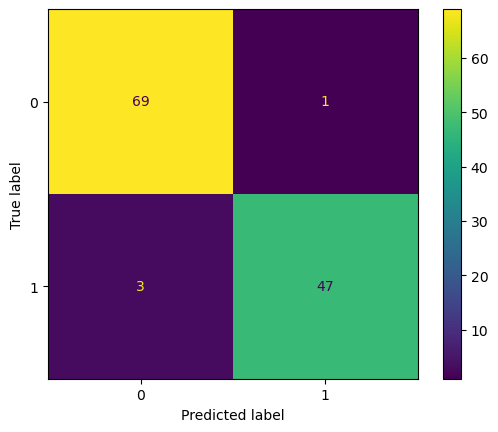

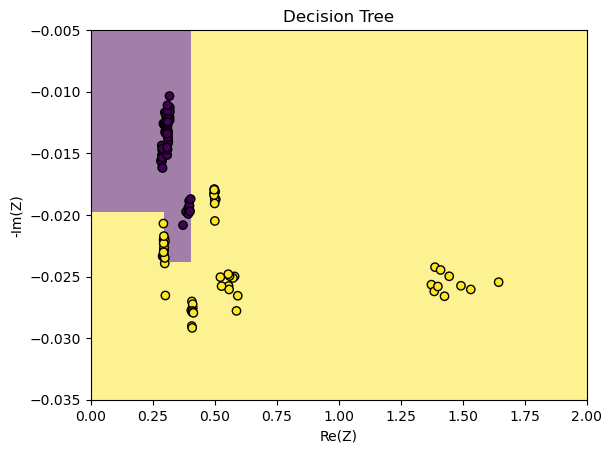

In [15]:
my_feats=['20004.453 Re','20004.453 Im']

model=DecisionTreeClassifier(criterion='gini',max_depth=5)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,plot_method='pcolormesh',grid_resolution=1000)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.0)
plt.ylim(-.035,-0.005)
plt.xlabel('Re(Z)')
plt.ylabel('-Im(Z)')
plt.title('Decision Tree')
plt.savefig('./Figures/IX_Full_Db_DTC_20kHz.png',format='png',dpi=600)
plt.show()
